In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 75,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-1, 1],
    c1 = 2.0,
    c2 = 2.0,
    w = 1.2,
    w_decay = 0.95,
    scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8271604938271605, Loss: 0.6551542635317202
Checkpoint 200, Accuracy: 0.8024691358024691, Loss: 0.6966604303430628
Checkpoint 300, Accuracy: 0.8271604938271605, Loss: 0.6631233074046947
Checkpoint 400, Accuracy: 0.8024691358024691, Loss: 0.673690018830476
Checkpoint 500, Accuracy: 0.8395061728395061, Loss: 0.6640927350079572


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None and title is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

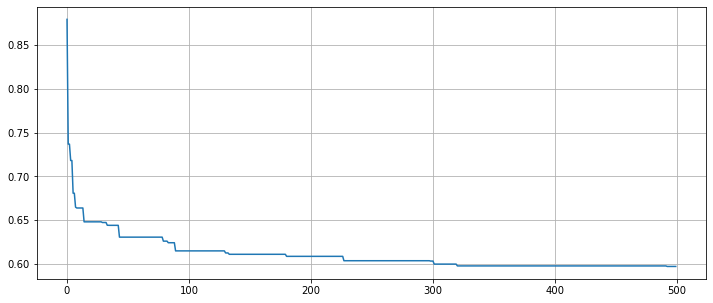

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [[0.90014386]
 [0.06429986]
 [0.03555636]]
[1. 0. 0.] <-> [[0.8020214 ]
 [0.13519153]
 [0.06278706]]
[1. 0. 0.] <-> [[0.91020346]
 [0.05790175]
 [0.03189475]]
[1. 0. 0.] <-> [[0.8981409 ]
 [0.06557549]
 [0.03628361]]
[0. 1. 0.] <-> [[0.1034071 ]
 [0.45439816]
 [0.4421948 ]]
[0. 0. 1.] <-> [[0.70323634]
 [0.19328213]
 [0.10348159]]
[1. 0. 0.] <-> [[0.89314616]
 [0.06880797]
 [0.03804591]]
[1. 0. 0.] <-> [[0.908152  ]
 [0.05921901]
 [0.03262892]]
[1. 0. 0.] <-> [[0.6603959 ]
 [0.23713872]
 [0.10246532]]
[1. 0. 0.] <-> [[0.8999274 ]
 [0.06443722]
 [0.03563543]]
[0. 0. 1.] <-> [[0.06305057]
 [0.47020337]
 [0.46674606]]
[1. 0. 0.] <-> [[0.8859903 ]
 [0.07354593]
 [0.04046379]]
[1. 0. 0.] <-> [[0.9072581 ]
 [0.05979089]
 [0.03295109]]
[1. 0. 0.] <-> [[0.4185276 ]
 [0.44693935]
 [0.13453308]]
[1. 0. 0.] <-> [[0.4716321 ]
 [0.31425577]
 [0.21411209]]
[1. 0. 0.] <-> [[0.89098656]
 [0.0796904 ]
 [0.02932316]]
[1. 0. 0.] <-> [[0.9057504 ]
 [0.06075154]
 [0.03349811]]
[1. 0. 0.] <->

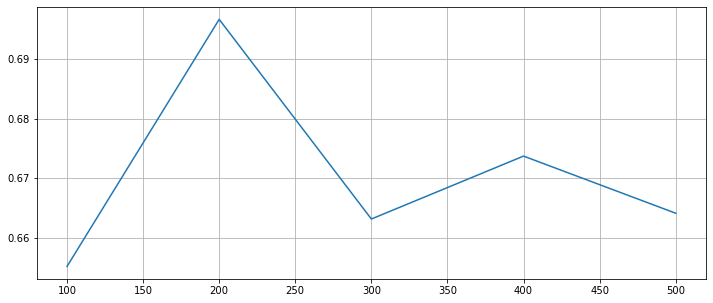

In [12]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

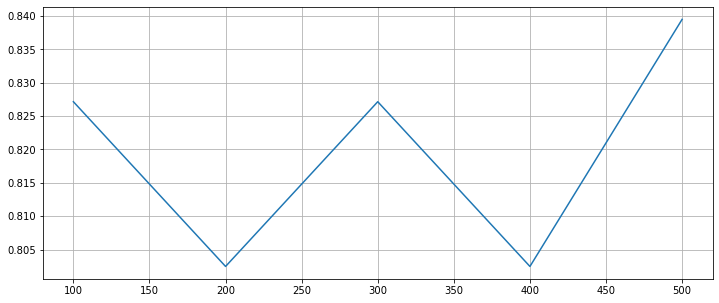

In [13]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[ 3.]
 [-3.]
 [-3.]
 [-3.]
 [-3.]]
 bias: [3.]

Neuron 1: weights:
[[-3.       ]
 [-3.       ]
 [-3.       ]
 [ 3.       ]
 [-2.2267218]]
 bias: [-0.08262738]

Neuron 2: weights:
[[ 1.4370061 ]
 [ 1.3459337 ]
 [-3.        ]
 [-3.        ]
 [ 0.00396257]]
 bias: [3.]

Neuron 3: weights:
[[-3.        ]
 [ 1.2881871 ]
 [ 3.        ]
 [-1.1914225 ]
 [ 0.80875444]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[-3.]
 [ 3.]
 [ 3.]
 [-3.]]
 bias: [3.]

Neuron 1: weights:
[[ 3.       ]
 [-1.2403167]
 [-1.5554217]
 [ 3.       ]]
 bias: [3.]

Neuron 2: weights:
[[ 3.        ]
 [-0.39210665]
 [-3.        ]
 [ 3.        ]]
 bias: [3.]

$

